# Taller de visualización y explicabilidad

En este taller vamos a ver de manera simplificada y a alto nivel algunas de las técnicas de visualización más utilizadas en la actualidad para la visualización de datos y su comprensión. 
La información presentada se descompone en:
* Técnicas de visualización clásicas
* Técnicas de visualización avanzadas
* écnicas de explicabilidad basadas en contrafactuales o contrafácticos

## Técnicas de explicabilidad basadas en contrafactuales o contrafácticos

### 1. Librería dice_ml

In [30]:
import dice_ml
from dice_ml.utils import helpers # helper functions
# Dataset for training an ML model
d = dice_ml.Data(dataframe=helpers.load_adult_income_dataset(),
                 continuous_features=['age', 'hours_per_week'],
                 outcome_name='income')

In [1]:
d.data_df.head(10)

NameError: name 'd' is not defined

In [12]:
from dice_ml.constants import BackEndTypes

In [13]:
# Pre-trained ML model
m = dice_ml.Model(model_path=dice_ml.utils.helpers.get_adult_income_modelpath(), backend=BackEndTypes.Tensorflow2)
# DiCE explanation instance
exp = dice_ml.Dice(d,m)

In [17]:
query_instance = {'age':22,
    'workclass':'Private',
    'education':'HS-grad',
    'marital_status':'Single',
    'occupation':'Service',
    'race': 'White',
    'gender':'Female',
    'hours_per_week': 45}

In [42]:
d.prepare_query_instance(query_instance).values

array([[22, 'Private', 'HS-grad', 'Single', 'Service', 'White', 'Female',
        45]], dtype=object)

In [43]:
d.de_normalize_data(d.prepare_query_instance(query_instance))

,age,workclass,education,marital_status,occupation,race,gender,hours_per_week
0,1623,Private,HS-grad,Single,Service,White,Female,4411


In [48]:
# Generate counterfactual examples
dice_exp = exp.generate_counterfactuals(query_instance, total_CFs=10, desired_class="opposite")
# Visualize counterfactual explanation
dice_exp.visualize_as_dataframe()

Diverse Counterfactuals found! total time taken: 02 min 05 sec
Query instance (original outcome : 0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,22.0,Private,HS-grad,Single,Service,White,Female,45.0,0.019



Diverse Counterfactual set (new outcome: 1.0)


,age,workclass,education,marital_status,occupation,race,gender,hours_per_week,income
0,30.0,Self-Employed,Doctorate,Married,Service,White,Female,17.0,0
1,56.0,Government,Doctorate,Widowed,Sales,White,Male,45.0,0
2,90.0,Private,Doctorate,Single,Professional,White,Male,45.0,0
3,50.0,Private,Bachelors,Married,White-Collar,White,Female,33.0,0
4,22.0,Self-Employed,Doctorate,Married,Professional,White,Female,45.0,0
5,43.0,Other/Unknown,Masters,Married,Service,White,Female,45.0,0
6,79.0,Private,Prof-school,Married,Service,Other,Female,45.0,0
7,32.0,Private,HS-grad,Married,Service,White,Female,96.0,0
8,22.0,Private,Prof-school,Married,Service,White,Female,63.0,0
9,51.0,Private,Doctorate,Single,White-Collar,Other,Male,71.0,0


In [ ]:
dice_exp = exp.generate_counterfactuals(query_instance,
                total_CFs=4, desired_class="opposite",
                features_to_vary=['age','workclass','education','occupation','hours_per_week'])

### 2. Librería alibi

In [50]:
import tensorflow as tf
tf.get_logger().setLevel(40) # suppress deprecation messages
tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_iris
from alibi.explainers import CEM

print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly()) # False

TF version:  2.9.1
Eager execution enabled:  False


In [51]:
dataset = load_iris()
feature_names = dataset.feature_names
class_names = list(dataset.target_names)

In [52]:
dataset.data = (dataset.data - dataset.data.mean(axis=0)) / dataset.data.std(axis=0)

In [53]:
idx = 145
x_train,y_train = dataset.data[:idx,:], dataset.target[:idx]
x_test, y_test = dataset.data[idx+1:,:], dataset.target[idx+1:]
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [54]:
def lr_model():
    x_in = Input(shape=(4,))
    x_out = Dense(3, activation='softmax')(x_in)
    lr = Model(inputs=x_in, outputs=x_out)
    lr.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    return lr

In [55]:
lr = lr_model()
lr.summary()
lr.fit(x_train, y_train, batch_size=16, epochs=500, verbose=0)
lr.save('iris_lr.h5', save_format='h5')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 3)                 15        
                                                                 
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________


In [56]:
idx = 0
X = x_test[idx].reshape((1,) + x_test[idx].shape)
print(f'Prediction on instance to be explained: {class_names[np.argmax(lr.predict(X))]}')
print(f'Prediction probabilities for each class on the instance: {lr.predict(X)}')

Prediction on instance to be explained: virginica
Prediction probabilities for each class on the instance: [[2.4579646e-04 2.4528468e-01 7.5446951e-01]]


In [57]:
mode = 'PN'  # 'PN' (pertinent negative) or 'PP' (pertinent positive)
shape = (1,) + x_train.shape[1:]  # instance shape
kappa = .2  # minimum difference needed between the prediction probability for the perturbed instance on the
            # class predicted by the original instance and the max probability on the other classes
            # in order for the first loss term to be minimized
beta = .1  # weight of the L1 loss term
c_init = 10.  # initial weight c of the loss term encouraging to predict a different class (PN) or
              # the same class (PP) for the perturbed instance compared to the original instance to be explained
c_steps = 10  # nb of updates for c
max_iterations = 1000  # nb of iterations per value of c
feature_range = (x_train.min(axis=0).reshape(shape)-.1,  # feature range for the perturbed instance
                 x_train.max(axis=0).reshape(shape)+.1)  # can be either a float or array of shape (1xfeatures)
clip = (-1000.,1000.)  # gradient clipping
lr_init = 1e-2  # initial learning rate

In [59]:
# define model
lr = load_model('iris_lr.h5')

# initialize CEM explainer and explain instance
cem = CEM(lr, mode, shape, kappa=kappa, beta=beta, feature_range=feature_range,
          max_iterations=max_iterations, c_init=c_init, c_steps=c_steps,
          learning_rate_init=lr_init, clip=clip)
cem.fit(x_train, no_info_type='median')  # we need to define what feature values contain the least
                                         # info wrt predictions
                                         # here we will naively assume that the feature-wise median
                                         # contains no info; domain knowledge helps!
explanation = cem.explain(X, verbose=False)

In [60]:
print(f'Original instance: {explanation.X}')
print(f'Predicted class: {class_names[explanation.X_pred]}')

Original instance: [[ 0.55333328 -1.28296331  0.70592084  0.92230284]]
Predicted class: virginica


In [61]:
print(f'Pertinent negative: {explanation.PN}')
print(f'Predicted class: {class_names[explanation.PN_pred]}')

Pertinent negative: [[ 0.5533333  -1.2829633  -0.60736364  0.92230284]]
Predicted class: versicolor


In [62]:
expl = {}
expl['PN'] = explanation.PN
expl['PN_pred'] = explanation.PN_pred

In [63]:
mode = 'PP'

In [64]:
# define model
lr = load_model('iris_lr.h5')

# initialize CEM explainer and explain instance
cem = CEM(lr, mode, shape, kappa=kappa, beta=beta, feature_range=feature_range,
          max_iterations=max_iterations, c_init=c_init, c_steps=c_steps,
          learning_rate_init=lr_init, clip=clip)
cem.fit(x_train, no_info_type='median')
explanation = cem.explain(X, verbose=False)

In [65]:
print(f'Pertinent positive: {explanation.PP}')
print(f'Predicted class: {class_names[explanation.PP_pred]}')

Pertinent positive: [[-7.44469730e-09 -3.47054341e-08  3.39384523e-01  9.13301240e-01]]
Predicted class: virginica


In [66]:
expl['PP'] = explanation.PP
expl['PP_pred'] = explanation.PP_pred

In [67]:
df = pd.DataFrame(dataset.data, columns=dataset.feature_names)
df['species'] = np.array([dataset.target_names[i] for i in dataset.target])

In [68]:
pn = pd.DataFrame(expl['PN'], columns=dataset.feature_names)
pn['species'] = 'PN_' + class_names[expl['PN_pred']]
pp = pd.DataFrame(expl['PP'], columns=dataset.feature_names)
pp['species'] = 'PP_' + class_names[expl['PP_pred']]
orig_inst = pd.DataFrame(explanation.X, columns=dataset.feature_names)
orig_inst['species'] = 'orig_' + class_names[explanation.X_pred]
df = df.append([pn, pp, orig_inst], ignore_index=True)

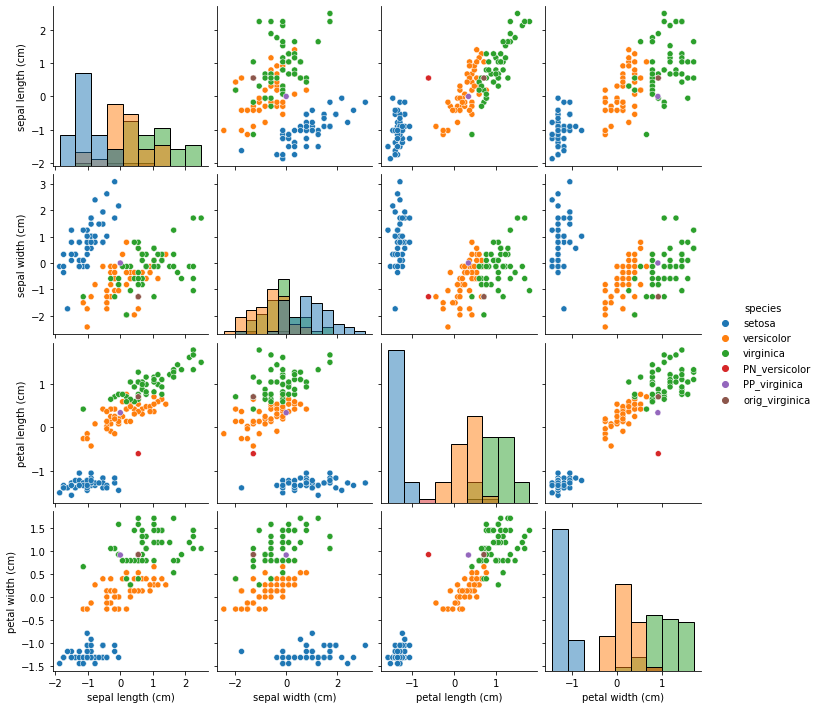

In [69]:
fig = sns.pairplot(df, hue='species', diag_kind='hist');

## Ejercicios
Repetir todas técnicas de visualización con el dataset proporcionado a continuación.

Enlace de descarga del dataset: https://www.kaggle.com/datasets/uciml/mushroom-classification?resource=download